# Demo Notebook - Lecture 11

In this lecture, we will investigate different methods for clustering time series:
- Aggregating the data
- Using distance metrics that can handle vectors (e.g. Euclidean distance)
- Using dynamic time warping

We will use spectral clustering for all experiments. Furthermore, we will again use a synthetic data set to explore the characteristics of the different approaches.

Using our synthetic data, we are interested in exploring procrastination. For this purpose, we will cluster the data of 30 high-school students based on their usage of an academic learning platform. The dataset contains the number of hours per biweek of the year that each student spent on the platform.

The dataset  is described by the following columns:

- student id: unique student identifier-
- biweek of the year: number of the biweek of the school year. Biweek 0 refers to the first two wekeks of the school year.
- hours: number of hours the student spent on the platform for that particular biweek-
- student type: expert tagging of student behavior, where (1) is procrastinators, (2) regular students, and (3) precrastinators. We will use the expert label as ground truth for the clustering.

In [1]:
#Important imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.metrics import cdist_dtw
from sklearn.preprocessing import StandardScaler

from scipy.spatial import distance
from scipy.sparse.csgraph import laplacian
from scipy import linalg
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import spectral_embedding

# Data directory
DATA_DIR = "./../data/"

In [2]:
df = pd.read_csv('{}/hours_biweek_students.csv'.format(DATA_DIR))
df.head()

,student_id,biweek_of_year,hours,student_type
0,0,0,39.915507,3
1,0,1,32.356082,3
2,0,2,17.456692,3
3,0,3,16.012725,3
4,0,4,15.859812,3


In a first step, we extract a time series (of biweeks) for each student.

In [3]:
def get_time_series(df):
    """
    reshapes DataFrame from long to wide and returns an np.array
    :param df: pd.DataFrame with data in long format
    :return: np.array with reshaped data
    """
    df_array = (df.sort_values(['student_id', 'biweek_of_year'], ascending=True)
                .groupby('student_id')
                .agg({'hours': lambda x: list(x)}))

    data = np.asarray(df_array.hours.values.tolist())
    return data


data = get_time_series(df)
data.shape

(30, 27)

We then plot the time series data for each student. The three student types are visually very well separable.

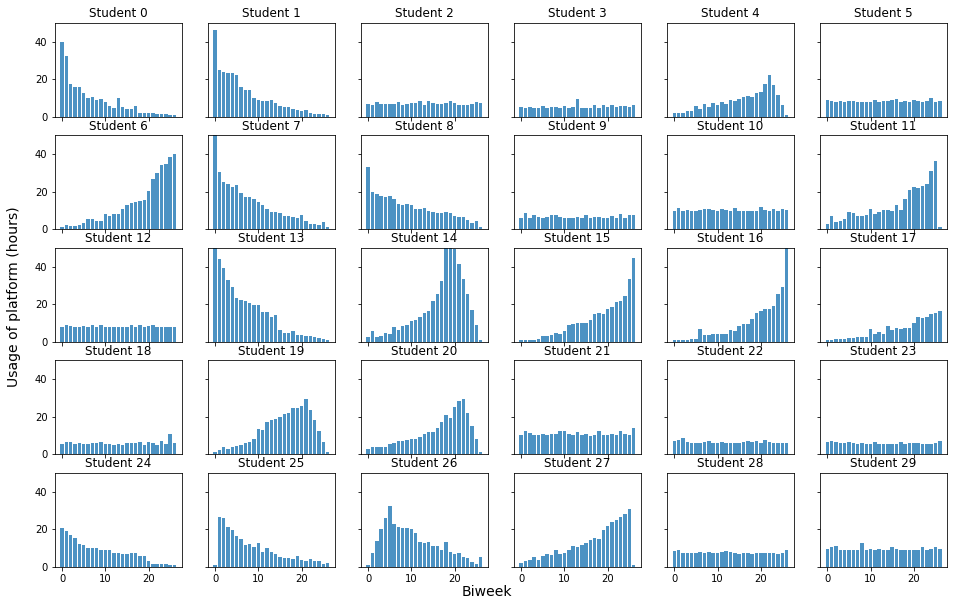

In [4]:
def plot_students(data):
    """
    Plot the students time-series
    :param data: np.array with students' time-series
    :return: 
    """
    students, biweeks = data.shape
    fig, axs = plt.subplots(5, 6, figsize=(16, 10), sharex=True,
                            sharey=True, facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(students):
        axs[i].bar(range(biweeks), data[i], alpha=0.8)
        axs[i].set_ylim([0, 50])
        axs[i].set_title('Student {0}'.format(i))
    fig.text(0.5, 0.09, 'Biweek', va='center', ha='center', fontsize=14)
    fig.text(0.09, 0.5, 'Usage of platform (hours)', va='center', ha='center', rotation='vertical', fontsize=14)


plot_students(data)

Next, we implement some helper functions needed to perform spectral clustering. Specifically, we provide the following functions:
- get_adjacency: computes the adjacency matrix W from a pairwise similarity matrix S
- spectral_clustering: performs spectral clustering for a given number of clusters k, based on an adjacency matrix W
- get_heuristics_spectral: performs spectral clustering for k=2,...,n clusters and computes the Silhouette score and eigengap heuristic for each k
- plot_metrics: visualizes the heuristics for the number of clusters

In [5]:
def get_adjacency(S, connectivity='full'):
    """
    Computes the adjacency matrix
    :param S: np array of similarity matrix
    :param connectivity: type of connectivity 
    :return: adjacency matrix
    """
    
    if(connectivity=='full'):
        adjacency = S
    elif(connectivity=='epsilon'):
        epsilon = 0.5
        adjacency = np.where(S > epsilon, 1, 0)
    else:
        raise RuntimeError('Method not supported')
        
    return adjacency

In [6]:
def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues 
        
    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted

In [7]:
def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]
    
    :param n_clusters_list: List of number of clusters to explore 
    :param metric_dictionary: 
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(3, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1

In [8]:
def get_heuristics_spectral(W, n_clusters_list, plot=True):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering
    
    :param W: np array of adjacency matrix
    :param n_clusters_list: List of number of clusters to explore
    :plot: bool, plot the metrics if true
    """
    silhouette_list = []
    eigengap_list = []
    
    df_labels = pd.DataFrame()

    for k in n_clusters_list:

        kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, k)
        y_pred = kmeans.labels_
        df_labels[str(k)] = y_pred

        if k == 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)


    metric_dictionary = {
                         'Silhouette': silhouette_list,
                         'Eigengap': eigenvals_sorted,
                        }
    
    if(plot):
        plot_metrics(n_clusters_list, metric_dictionary)
        return df_labels
    else:
        return df_labels, metric_dictionary

## 1 - Aggregated Data

The first method we will explore is aggregating features over time. In our example, we will use the mean for the aggreation. We therefore first compute the mean value of our feature (number of hours per biweek) over the whole time series.

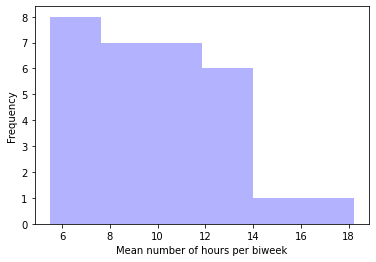

In [9]:
# compute the average of the feature over the whole time series
aggregated_data = np.mean(data, axis = 1)

# plot the histogram of the feature for all students
plt.hist(aggregated_data, bins = 6, alpha = 0.3, color = 'blue')
plt.xlabel('Mean number of hours per biweek')
plt.ylabel('Frequency');

We then again build a similarity matrix and a similarity graph and perform spectral clustering for k=2,...10 clusters. We visualize the Silhouette score and the eigengap heuristic.

In [10]:
S = pairwise_kernels(aggregated_data.reshape(-1,1), metric='rbf', gamma=1)

In [11]:
W =  get_adjacency(S) 

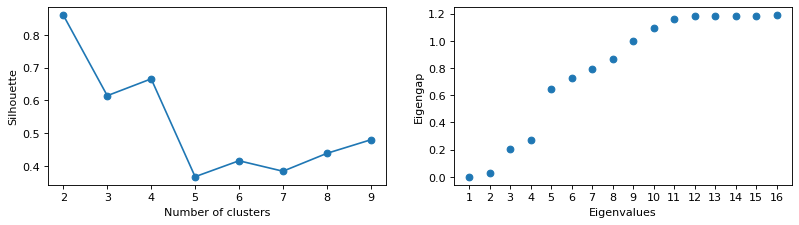

In [12]:
n_cluster_list = range(2, 10)
df_labels = get_heuristics_spectral(W, n_cluster_list)

Next, we want to visualize the time series of the students in the different clusters. We implement a function `view_clusters`, which visualizes the average behavior for each cluster. We also implement a function `plot_students_group`, which visualizes the time series of the students in each group.

In [15]:
def view_clusters(data, labels, ylim = 70, xlabel= 'Biweeks'):
    """
    visualize the different time-series of students belonging to each cluster. 
    :param data: np.array with students' time-series
    :param labels: np.array predicted labels from clustering model
    :return: 
    """
    _, biweeks = data.shape
    clusters = np.unique(labels).shape[0]
    fig, axs = plt.subplots(1, clusters, figsize=(16, 4), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    for i in range(clusters):
        students_cluster = data[labels == i]
        number_students = students_cluster.shape[0]
        for student in range(number_students):
            axs[i].bar(range(biweeks), students_cluster[student], alpha=0.3)
        
        axs[i].set_ylim([0, ylim])
        axs[i].set_title('Group {0}'.format(i))
        axs[i].set_ylabel('Hours using platform')
        axs[i].set_xlabel(xlabel)

In [16]:
def plot_students_group(data, labels):
    """
    Plot the students time-series
    :param data: np.array with students' time-series
    :param labels: pd.Series indicating the labels of the students
    :return: 
    """
    for group in np.unique(labels):
        subdata = data[labels==group]
        subindex = labels[labels==group].index
        students, biweeks = subdata.shape

        rows = int(np.ceil(students/6))
        fig, axs = plt.subplots(rows, 6, figsize=(16, rows*3), sharex=True,
                            sharey=True, facecolor='w', edgecolor='k')

        axs = axs.ravel()
        for i in range(students):
            axs[i].bar(range(biweeks), subdata[i], alpha=0.8)
            axs[i].set_ylim([0, 50])
            axs[i].set_title('Student {0}'.format(subindex[i]))
        
        fig.suptitle('GROUP {}'.format(group))
        fig.supxlabel('Biweek')
        fig.supylabel('Usage of platform (hours)')
        plt.tight_layout()
        plt.show()

Both the Silhouette score and the eigengap heuristic suggest that the optimal number of clusters is 2. We visualize the mean behavior as well as the time series data of the students in each group.

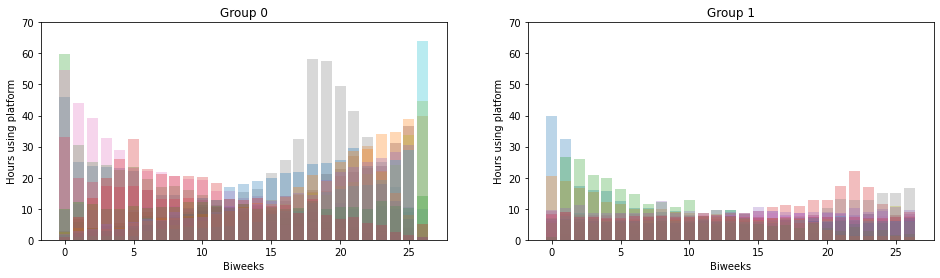

In [17]:
k = 2
view_clusters(data, df_labels[str(k)])

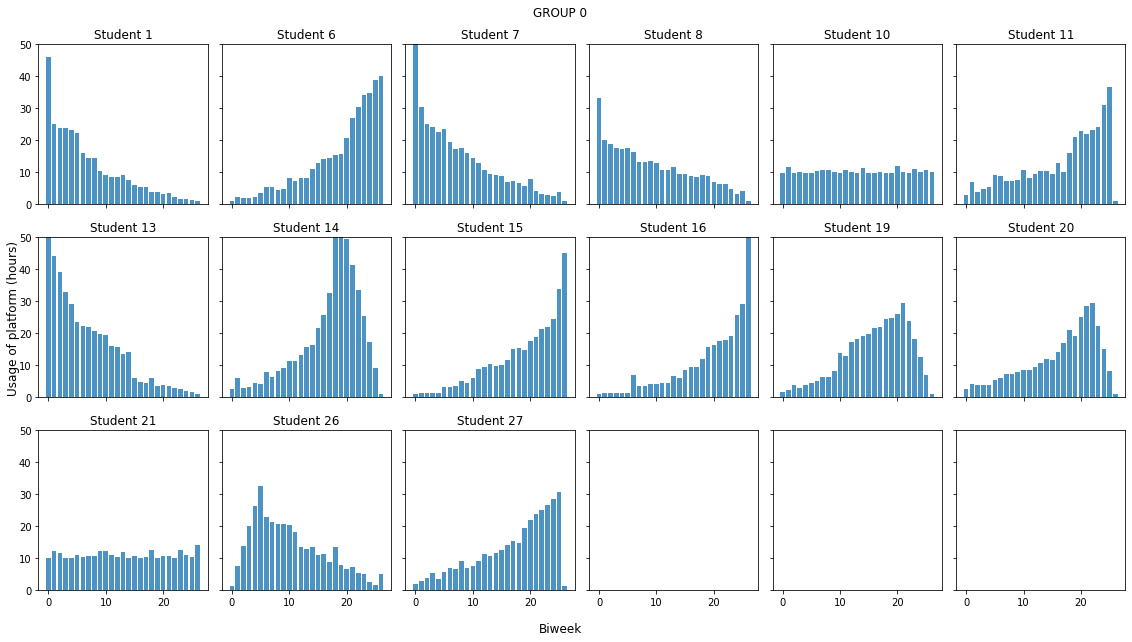

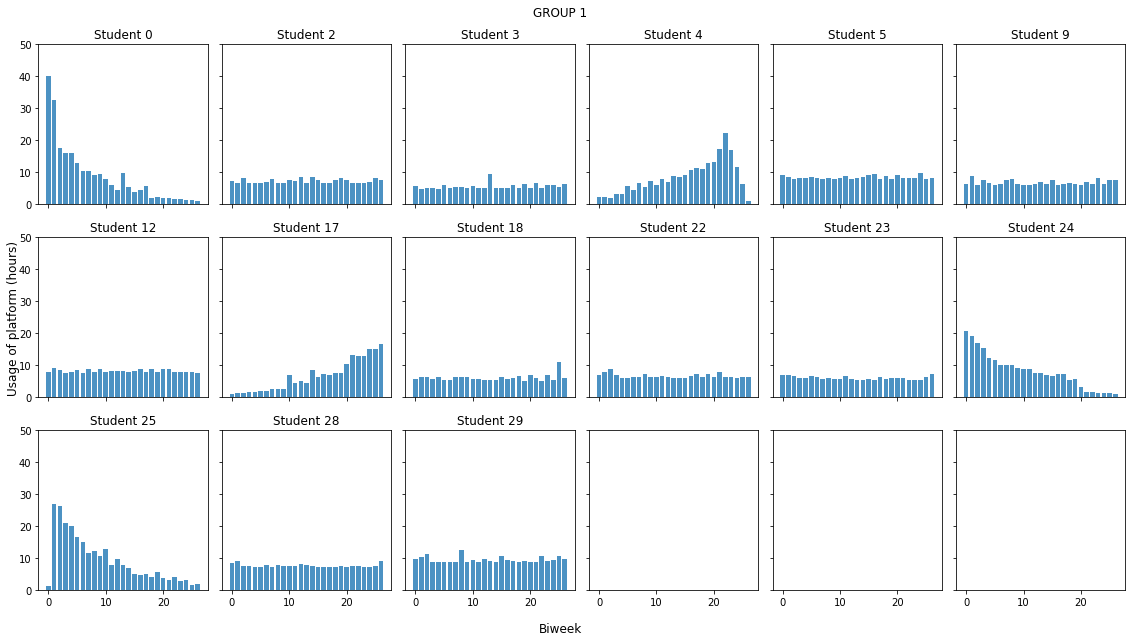

In [18]:
plot_students_group(data, df_labels[str(k)])

We observe that when using aggregated features, we obtain a "high effort" and a "low effort" group, i.e. one group of students spending significantly more time on the platform on average than the other group of students. Using aggregated features, we are not able to take into account the shape of the time series.

## 2 - Assuming fixed time intervals

Given the fact that all the students have the same number of biweeks (worth a year), the time series of each student has the same length. We can therefore simply use the Euclidean distance to compute the pairwise distances. In order to avoid clustering by the absolute number of hours and capture students individual differences over the semester (i.e. students who work more at the beginning of the semester and then less over the course of the semester) we normalize the data for each student (i.e. within the student's time series).

In [19]:
X = data
norms = np.linalg.norm(X, axis=1)
data_normalized = X / norms[:, np.newaxis]

We then again perform a spectral clustering and visualize the heuristics.

In [20]:
S = pairwise_kernels(data_normalized, metric='rbf', gamma=1)
W =  get_adjacency(S) 

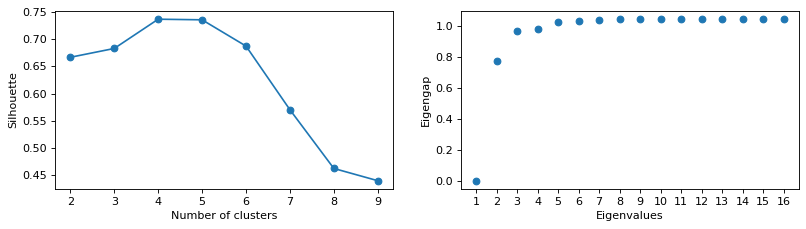

In [21]:
n_cluster_list = range(2, 10)
df_labels = get_heuristics_spectral(W, n_cluster_list)

The Silhouette score suggests that the optimal number of clusters is 4, while according to the eigengap heuristic, the optimal number of clusters is 2.
We therefore visualize the behavior for 2 and 4 clusters.

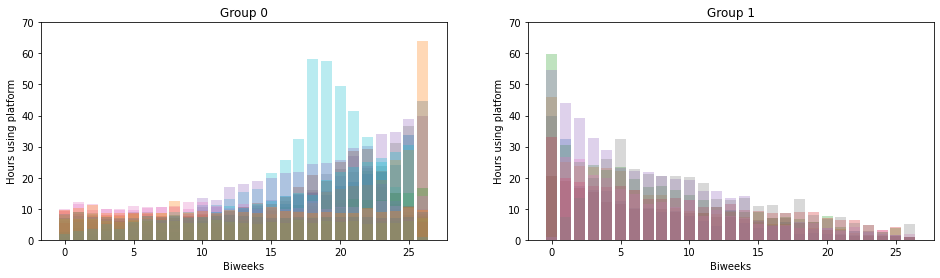

In [22]:
k = 2
view_clusters(data, df_labels[str(k)])

For 2 clusters, we seem to obtain one group with students working at the end of the semester and one group with students at the beginning of the semester. However, when we look into the actual timelines of the students in the clusters, we observe that also students with peaks in the end or no peaks get assigned to group 0.

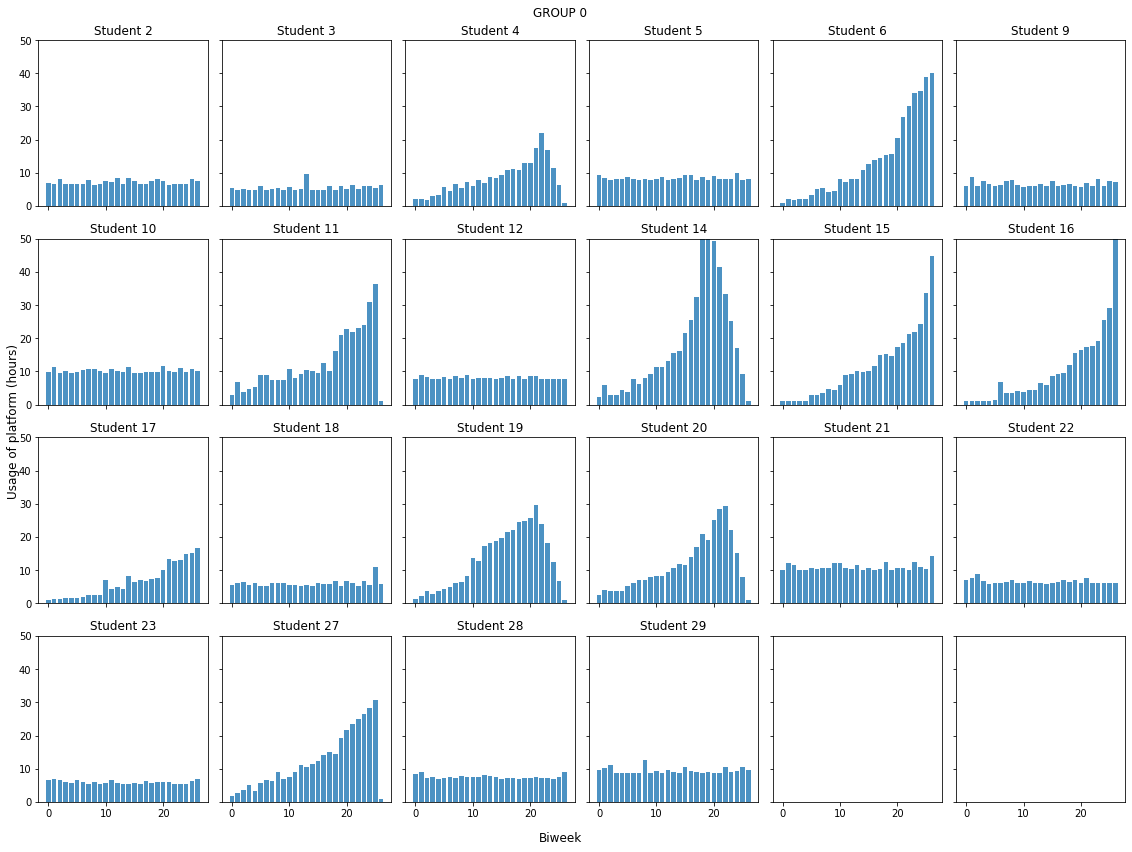

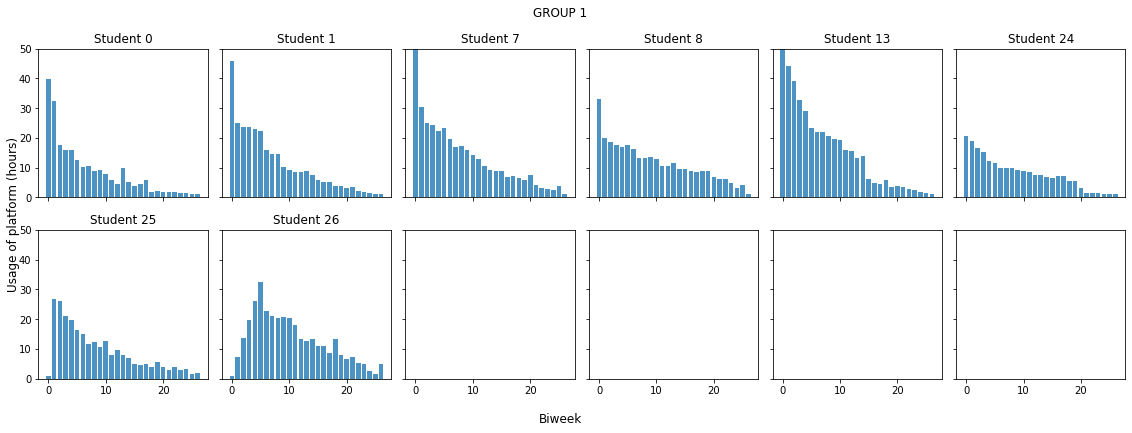

In [23]:
plot_students_group(data, df_labels[str(k)])

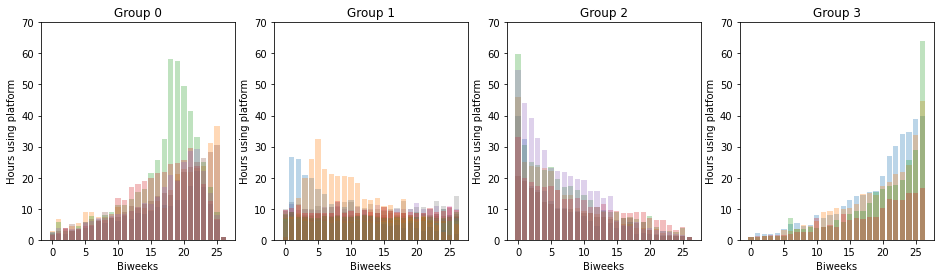

In [24]:
k = 4
view_clusters(data, df_labels[str(k)])

When using 4 clusters, we get a group with peaks in the beginning (group 2), a group with no peaks (group 1), and two groups (group 0 and group 3) with peaks towards the end.

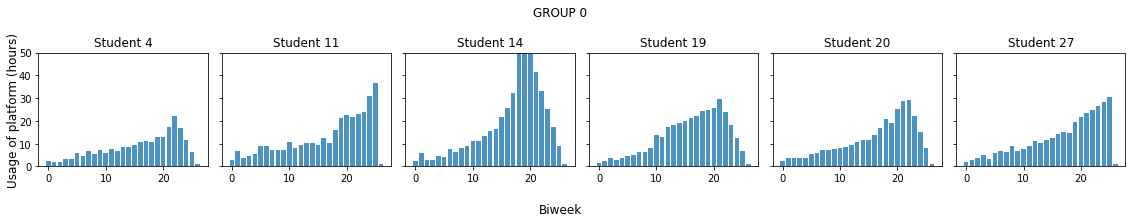

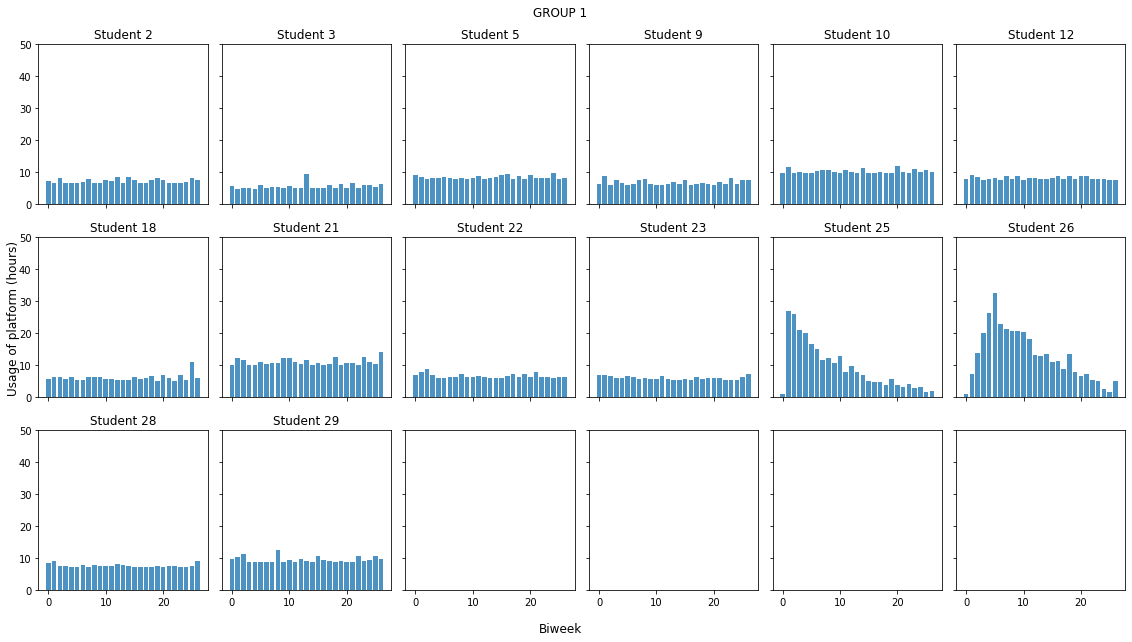

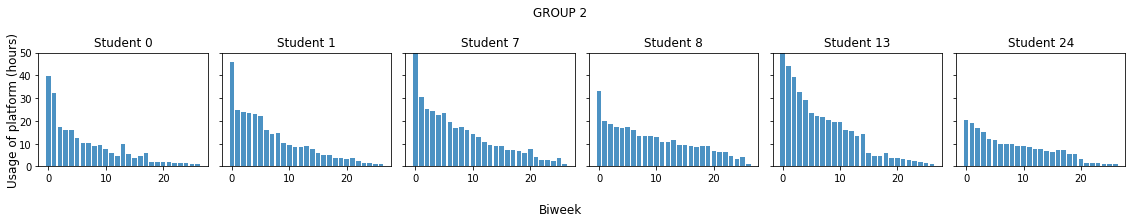

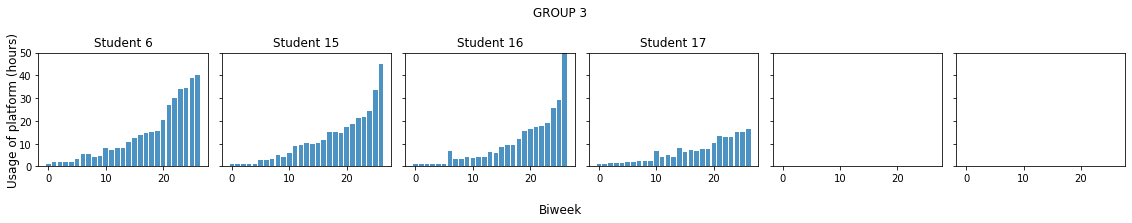

In [25]:
plot_students_group(data, df_labels[str(k)])

We observe that using Euclidean distance, the clustering is very sensitive to the peaks, i.e. tries to exactly align the peaks. If two students i and j do both have peaks in the end but not in the exact same biweek, the pairwise distance between them can get very large.

## 3- Dynamic Time Warping

Dynamic time warping allows us to align to sequences in an optimal way by choosing a window size w larger than 0.

We first implement a distance function for computing the dynamic time warping distance for a fixed window size w.

In [26]:
def get_distance_matrix(X, metric='euclidean', window=2):
    """
    calculates distance matrix given a metric
    :param X: np.array with students' time-series
    :param metric: str distance metric to compute
    :param window: int for DTW
    :return: np.array with distance matrix
    """
    norms = np.linalg.norm(X, axis=1)
    data_normalized = X / norms[:, np.newaxis]

    if metric == 'dtw':
        distance_matrix = cdist_dtw(data_normalized,
                                    global_constraint='sakoe_chiba',
                                    sakoe_chiba_radius=window)
    else:
        distance_vector = distance.pdist(data_normalized, metric)
        distance_matrix = distance.squareform(distance_vector)
    return distance_matrix

We then also implement a function that computes the similarity matrix for us based on the pairwise distances.

In [27]:
def get_affinity_matrix(D, gamma=1):
    """
    calculates affinity matrix from distance matrix
    :param D: np.array distance matrix
    :param gamma: float coefficient for Gaussian Kernel
    :return:
    """
    S = np.exp(-gamma * D ** 2)
    return S

We then compute pairwise distances using a window size of 6. Subsequently, we compute the similarity matrix and the adjacency matrix and then again perform spectral clustering and visualize the cluster heuristics.

In [28]:
D = get_distance_matrix(data, metric='dtw', window=6)

In [29]:
S = get_affinity_matrix(D)
W = get_adjacency(S)

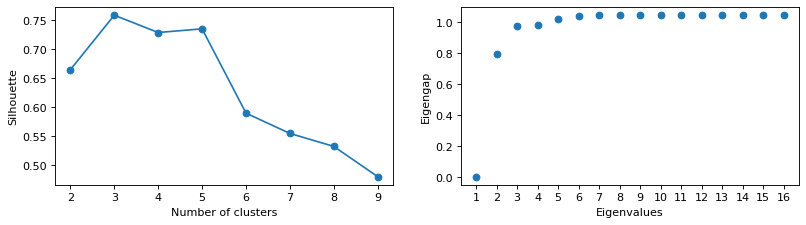

In [30]:
n_cluster_list = range(2, 10)
df_labels = get_heuristics_spectral(W, n_cluster_list)

We observe that the Silhouette score suggests that the optimal number of clusters is 3, while the eigengap heuristic suggests 2 clusters. 
We visualize the clustering solution for k=3.

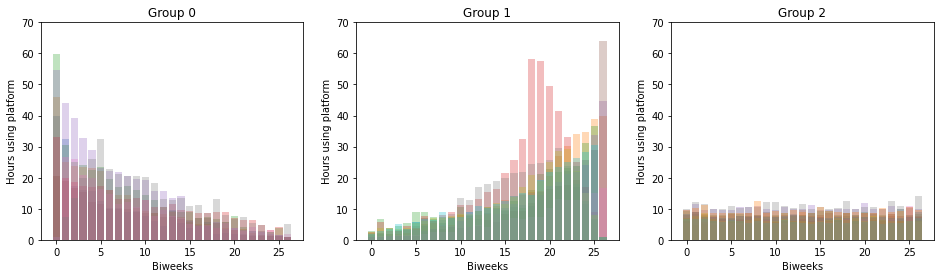

In [31]:
k = 3
view_clusters(data, df_labels[str(k)])

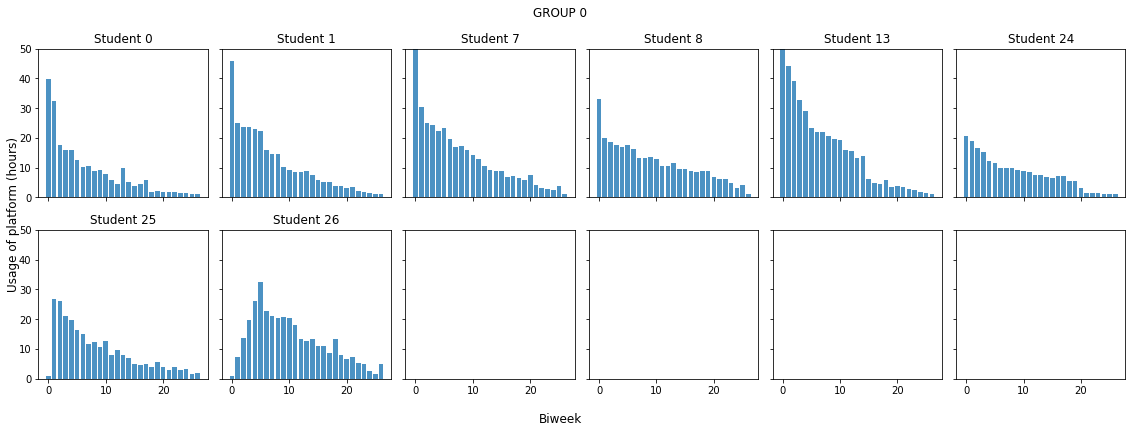

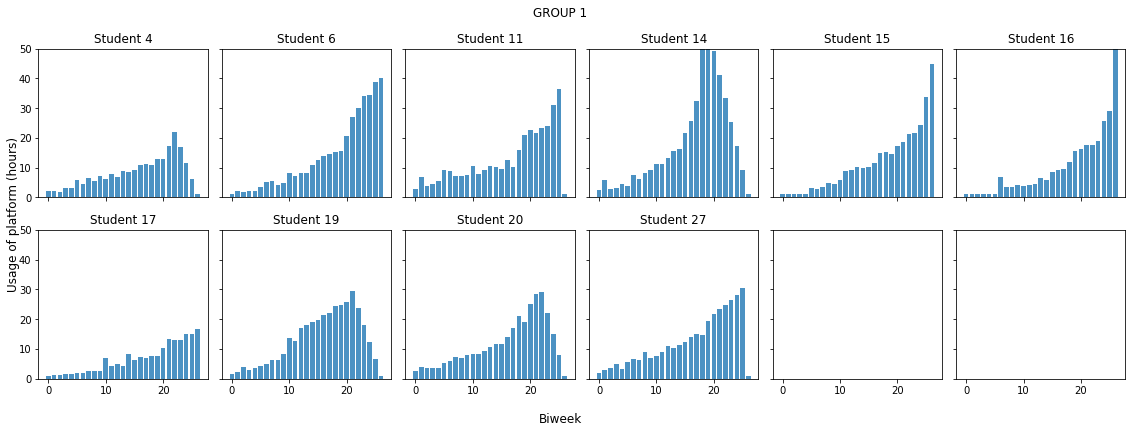

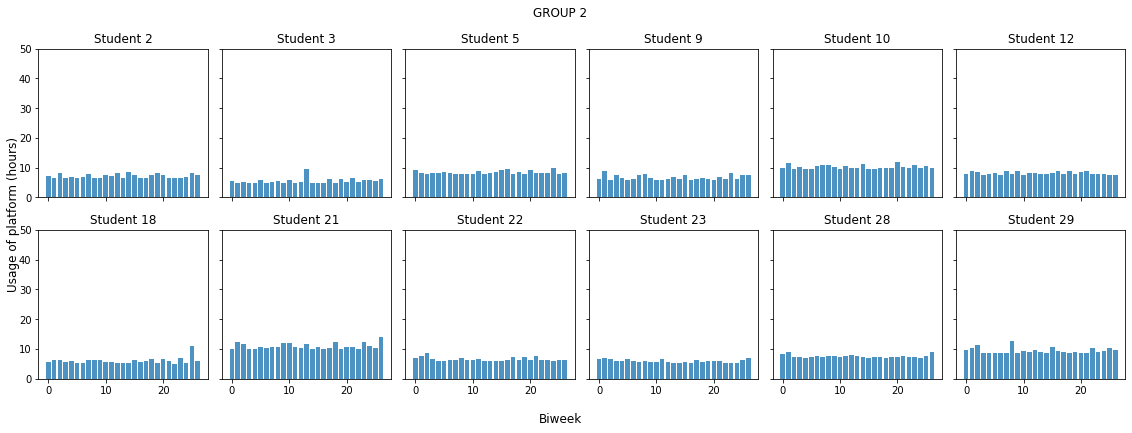

In [32]:
plot_students_group(data, df_labels[str(k)])

Finally, we play with the window size w. We choose a very small window size (w = 0) and a very large window size (w = 27).

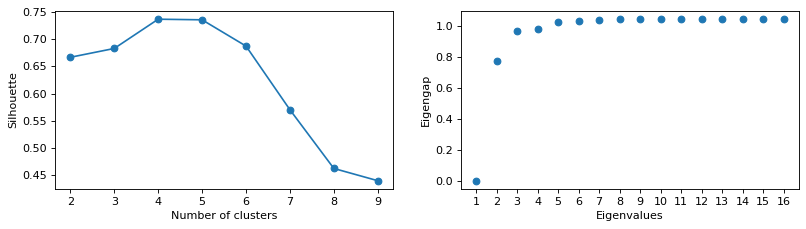

In [33]:
# windows size 0
D = get_distance_matrix(data, metric='dtw', window=0)
S = get_affinity_matrix(D)
W = get_adjacency(S)
n_cluster_list = range(2, 10)
df_labels = get_heuristics_spectral(W, n_cluster_list)

Using w=0 is equal to just simply computing Euclidean distance and therefore, we obtain exactly the same results as with the fixed time intervals method.

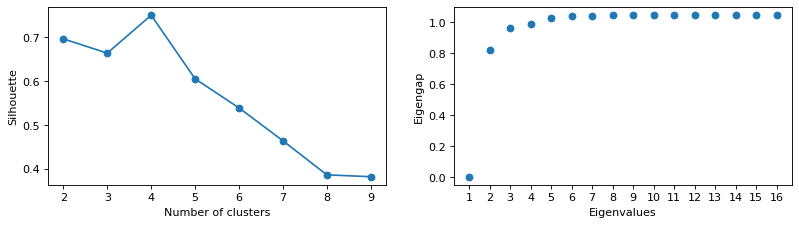

In [34]:
# windows size 27
D = get_distance_matrix(data, metric='dtw', window=27)
S = get_affinity_matrix(D)
W = get_adjacency(S)
n_cluster_list = range(2, 10)
df_labels = get_heuristics_spectral(W, n_cluster_list)

We again visualize the cluster solution as determined by the Silhouette score. Choosing a very large window size (w= 27) leads to the fact that the DTW can align time series across the year (i.e. students with peaks in the beginning can be close to students with peaks in the end of the year).

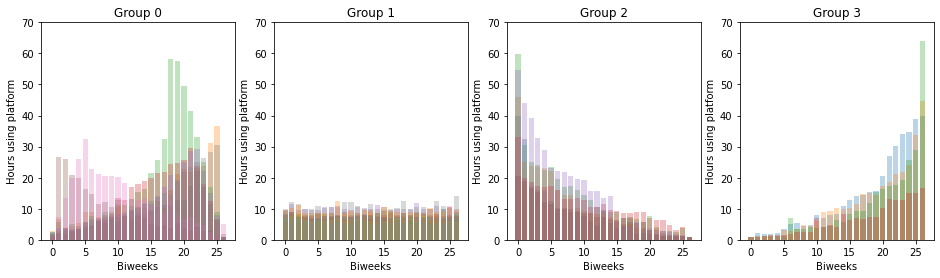

In [35]:
k = 4
view_clusters(data, df_labels[str(k)])

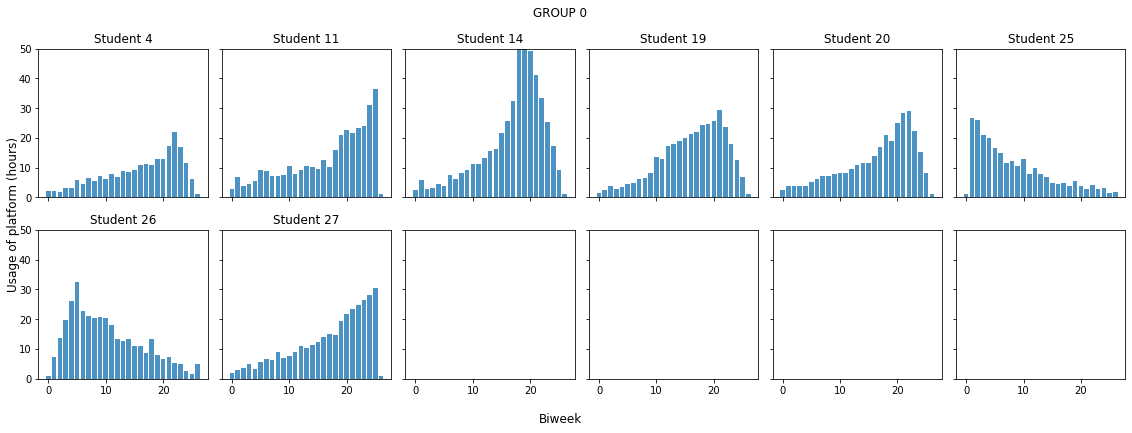

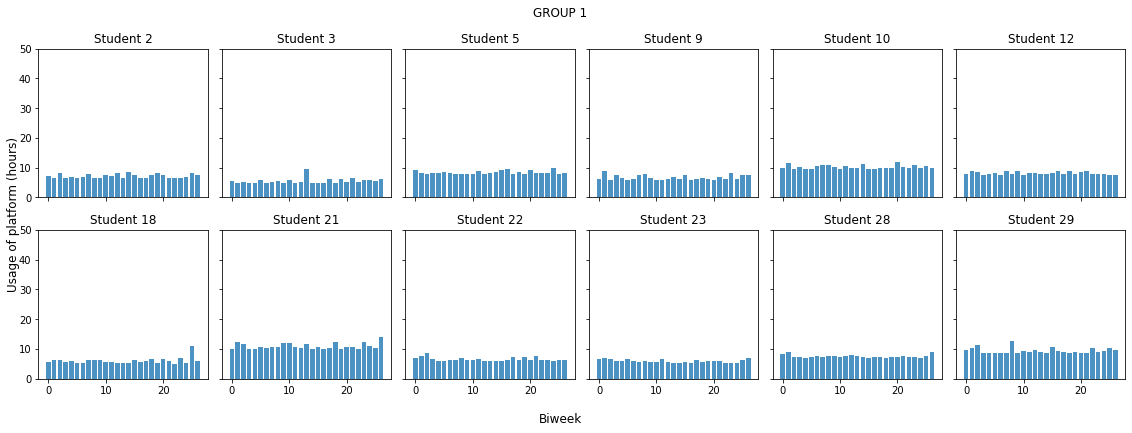

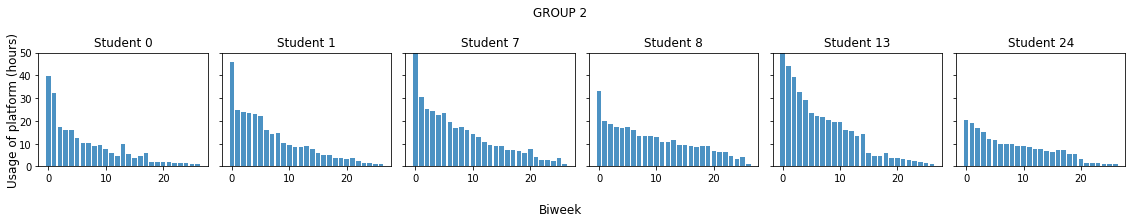

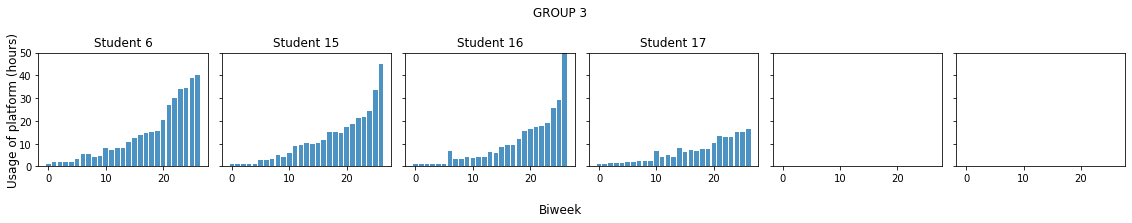

In [36]:
plot_students_group(data, df_labels[str(k)])

## 4 - Clustering the flipped classroom data

We are also interested in procastrination behavior in our flipped classroom.  We first parse and preprocess the data.

In [37]:
df = pd.read_csv('{}/time_series_extended_fc.csv'.format(DATA_DIR))
df = df.fillna('NaN')
df.head()

,week,user,ch_num_sessions,ch_time_in_prob_sum,ch_time_in_video_sum,ch_ratio_clicks_weekend_day,ch_total_clicks_weekend,ch_total_clicks_weekday,ch_time_sessions_mean,ch_time_sessions_std,...,la_seek_len_std,la_pause_dur_std,la_time_speeding_up_mean,la_time_speeding_up_std,la_weekly_prop_watched_mean,la_weekly_prop_interrupted_mean,la_weekly_prop_interrupted_std,la_weekly_prop_replayed_mean,la_weekly_prop_replayed_std,la_frequency_action_video_play
0,0,0,4.0,5682.0,6417.0,8.500000,12.0,102.0,1707.750000,810.546536,...,96.481703,391.625902,93.987805,253.735194,0.5,0.1,0.0,0.1,0.0,0.298246
1,0,1,7.0,326.0,15525.0,5.675000,40.0,227.0,1931.285714,1648.472515,...,146.564097,188.175709,65.173554,150.807752,0.6,0.1,0.0,0.0,0.0,0.400749
2,0,2,4.0,1224.0,12209.0,258.000000,1.0,258.0,2780.250000,2297.110400,...,33.419147,39.702700,0.000000,0.000000,0.6,0.0,0.0,0.0,0.0,0.370656
3,0,3,11.0,3517.0,26500.0,14.100000,10.0,141.0,1197.545455,1114.889343,...,85.642099,807.114957,0.000000,0.000000,0.9,0.0,0.0,0.1,0.0,0.258278
4,0,4,4.0,1294.0,12037.0,0.328571,140.0,46.0,3043.750000,344.374342,...,159.612354,228.274335,67.941176,111.514074,0.3,0.0,0.0,0.2,0.0,0.252688


To be able to assess relative behavior across weeks of the semester, we normalize the features we are interested in for each student:
`ch_time_in_prob_sum`, `ch_time_in_video_sum`, `ch_total_clicks_weekend`, `ch_total_clicks_weekday`
We first again compute the time spent on the platform in each week and the total number of clicks in each week.

In [38]:
df['ch_time_sum'] = df.ch_time_in_prob_sum + df.ch_time_in_video_sum
df['ch_total_clicks'] = df.ch_total_clicks_weekend + df.ch_total_clicks_weekday

Before proceeding, we need again to extract the time series for each user and feature.

In [39]:
def get_time_series(df):
    """
    reshapes DataFrame from long to wide and returns an np.array
    :param df: pd.DataFrame with data in long format
    :return: np.array with reshaped data
    """
    df_array = (df.sort_values(['user', 'week'], ascending=True)
                .groupby('user')
                .agg({'ch_time_sum': lambda x: list(x),
                      'ch_total_clicks': lambda x:list(x)}))

    data_time = np.asarray(df_array.ch_time_sum.values.tolist())
    data_clicks = np.asarray(df_array.ch_total_clicks.values.tolist())
    return data_time, data_clicks

In [40]:
data_time, data_clicks = get_time_series(df)

In [41]:
data_time.shape

(288, 10)

We then use the normalized features as a basis for the clustering.

In [42]:
D1 = get_distance_matrix(data_time, metric='dtw', window=1)
D2 = get_distance_matrix(data_clicks, metric='dtw', window=3)

In [43]:
S1 = get_affinity_matrix(D1, gamma=4)
S2 = get_affinity_matrix(D2, gamma=10)
S = (S1 + S2) / 2

W = get_adjacency(S)

We then use spectral clustering for k=2,...,10 clusters.

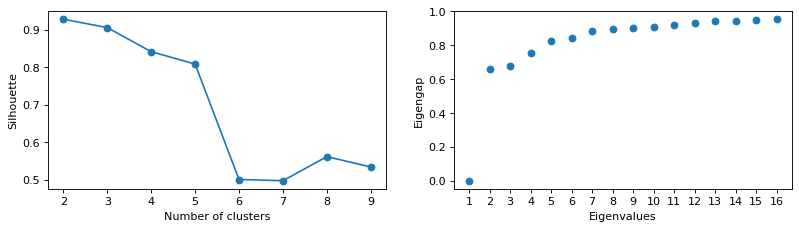

In [44]:
n_cluster_list = range(2, 10)
df_labels = get_heuristics_spectral(W, n_cluster_list)

Both metrics suggest that two clusters seem to be optimal.

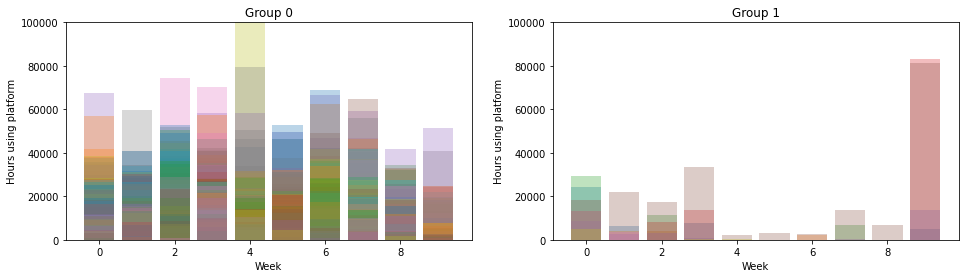

In [45]:
k = 2
view_clusters(data_time, df_labels[str(k)], ylim = 100000, xlabel = 'Week')

In [43]:
def plot_mean(data, labels, ylim=1): 
    """
    visualize the different time-series of students belonging to each cluster. 
    :param data: np.array with students' time-series
    :param labels: np.array predicted labels from clustering model
    :return: 
    """
    _, weeks = data.shape
    clusters = np.unique(labels).shape[0]
    fig, axs = plt.subplots(1, clusters, figsize=(16, 4), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    dim = data.shape[1]
    
    for i in range(clusters):
        students_cluster = data[labels == i]
        boxplot_data = [students_cluster[:,i] for i in range(dim)]
        pos = [i+1 for i in range(dim)]
        values =  np.mean(students_cluster, axis = 0)
        axs[i].bar(pos, values, alpha=0.3)
        
        axs[i].set_title('Group {0}'.format(i))
        axs[i].set_xlabel('Week')
        axs[i].set_ylim(0, ylim)
        
    plt.show()

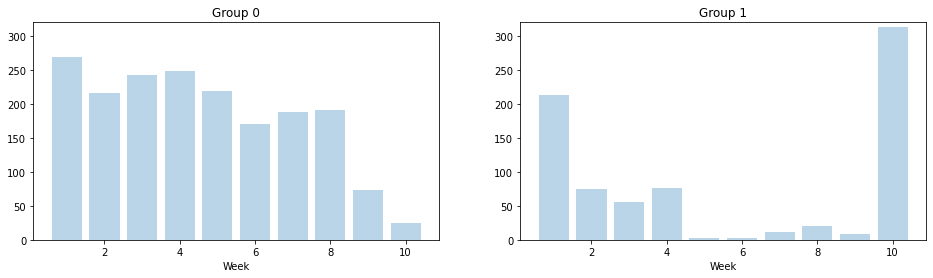

In [44]:
plot_mean(data_clicks, df_labels[str(k)], ylim=320)

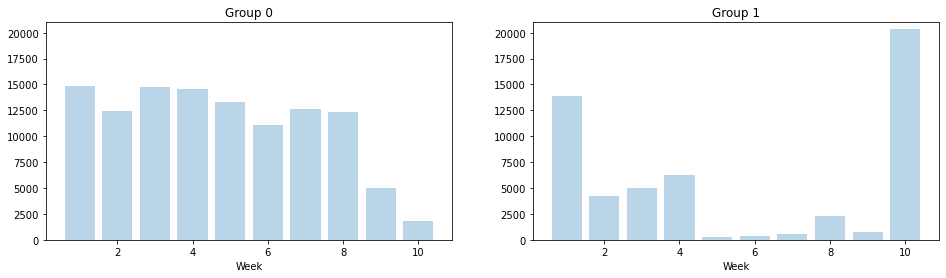

In [45]:
plot_mean(data_time, df_labels[str(k)], ylim = 21000)

We observe that we obtain two clusters of student: one cluster working regularly over the course of the semester and a second group with a peak at the end.